# Finite size scaling

In this notebook we will discuss the use of a finite size scaling ansatz to measure properties of a percolating system. So far we've treated the finite systems as if they were in reality infinte.

We will start by finding the percolation threshold $p_{\Pi = x}$ for which the percolation probability $\Pi(p_{\Pi = x}) = x$. That is, we generate many systems of size $L$ with a specific probability $p$ and compute the average percolation probability. We improve on our choice of $p$ until we reach a point where $\Pi(p) \approx x$. The value of $p$ at this point will be $p_{\Pi = x}$.

In [14]:
import numpy as np
import scipy.optimize
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from percolation import compute_percolation_threshold
import sklearn.linear_model

In [2]:
sns.set()

In [3]:
L_list = [25, 50, 100, 200, 400, 800]
M = 100

x_high = 0.8
x_low = 0.3

p_pi_high = []
p_pi_low = []

In [4]:
for L in tqdm.tqdm_notebook(L_list):
    p_pi = compute_percolation_threshold(x_high, L, M, p_bounds=(0, 1))
    print(f"(high) p = {p_pi}")
    p_pi_high.append(p_pi)

    p_pi = compute_percolation_threshold(x_low, L, M, p_bounds=(0, 1))
    p_pi_low.append(p_pi)
    print(f"(low) p = {p_pi}")

(high) p = 0.6104202270507812
(low) p = 0.5485763549804688
(high) p = 0.5994796752929688
(low) p = 0.5668716430664062
(high) p = 0.5986404418945312
(low) p = 0.5780868530273438
(high) p = 0.5955581665039062
(low) p = 0.5859451293945312
(high) p = 0.5945358276367188
(low) p = 0.5880203247070312
(high) p = 0.5939865112304688
(low) p = 0.5892257690429688



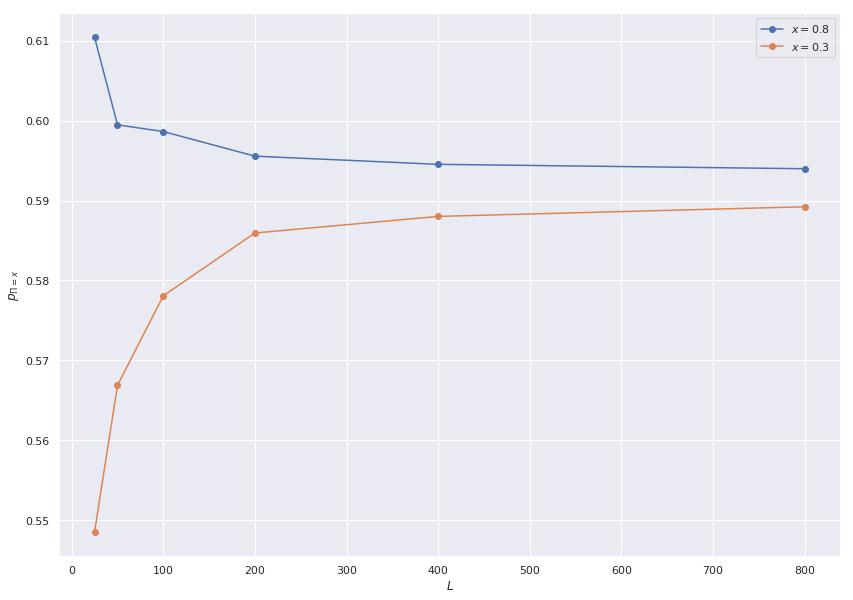

In [11]:
fig = plt.figure(figsize=(14, 10))

plt.plot(L_list, p_pi_high, label=fr"$x = {x_high}$", marker="o")
plt.plot(L_list, p_pi_low, label=fr"$x = {x_low}$", marker="o")
plt.legend(loc="best")
plt.xlabel(r"$L$")
plt.ylabel(r"$p_{\Pi = x}$")
plt.show()

## Scaling as a function of system size

We know that the scaling theory for the percolation threshold can be found from
\begin{align}
    p_{\Pi = \Delta x}
    \equiv
    p_{\Pi = x_1} - p_{\Pi = x_2}
    = \left( C_{x_1} - C_{x_2} \right) L^{-1 / \nu}.
\end{align}
Taking the logarithm on both sides, we can compute an estimate for the exponent $-1 / \nu$.
\begin{align}
    \log\left( p_{\Pi = \Delta x} \right)
    = \log \left( C_{x_1} - C_{x_2} \right)
    - \frac{1}{\nu}\log\left( L \right).
\end{align}

In [12]:
p_diff = np.array(p_pi_high) - np.array(p_pi_low)
L_arr = np.array(L_list)

Below we do linear regression to find an estimate for the exponent $\nu$.

In [15]:
log_p_diff = np.log(p_diff)
log_L_arr = np.log(L_arr)

clf = sklearn.linear_model.LinearRegression().fit(
    log_L_arr[:, np.newaxis], log_p_diff[:, np.newaxis]
)

neg_inv_nu = clf.coef_[0, 0]
log_C_diff = clf.intercept_[0]

In [29]:
nu = -1 / neg_inv_nu

print(f"nu = {nu}")

nu = 1.317621059977864


The true value of $\nu$ for $2$ dimensions is $\nu = 4 / 3 \approx 1.3333$.

In [30]:
nu_true = 4 / 3

print(f"Diff in nu from true value: {np.abs(nu_true - nu)}")

Diff in nu from true value: 0.01571227335546932


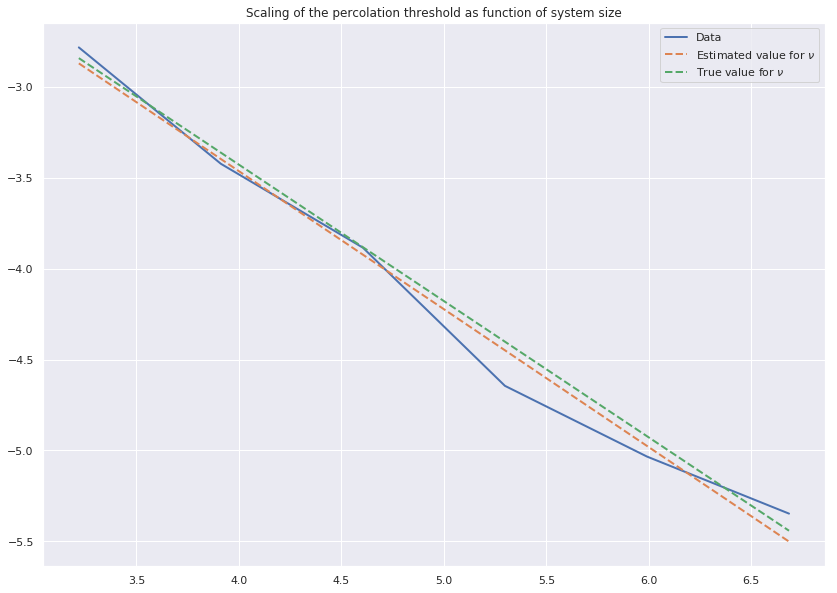

In [32]:
plt.figure(figsize=(14, 10))

plt.plot(
    log_L_arr,
    log_p_diff,
    lw=2,
    label=r"Data"
)
plt.plot(
    log_L_arr,
    log_C_diff + neg_inv_nu * log_L_arr,
    "--",
    lw=2,
    label=r"Estimated value for $\nu$"
)
plt.plot(
    log_L_arr,
    log_C_diff - 1 / nu_true * log_L_arr,
    "--",
    lw=2,
    label=r"True value for $\nu$"
)
plt.legend(loc="best")
plt.title(r"Scaling of the percolation threshold as function of system size")
plt.show()

Here we have plotted the computed values for the scaling of the difference between two percolation thresholds, versus the theoretical model using both the estimated value for $\nu$ and the "true" value. We see that the values are pretty close.

## Estimating the critical percolation probability

Using scaling theory from the percolation threshold, we can estimate the critical percolation probability $p_c$ by
\begin{align}
    p_{\Pi = x} = p_c + C_x L^{-1 / \nu},
\end{align}

where $\nu = 4 / 3$ is the exact known value. Again we use linear regression to estimate the coefficient $C_x$ and the intercept, i.e., the critical percolation probability, $p_c$.

In [33]:
p_pi_high_arr = np.array(p_pi_high)
p_pi_low_arr = np.array(p_pi_low)

In [46]:
clf_high = sklearn.linear_model.LinearRegression().fit(
    L_arr[:, np.newaxis] ** (-1 / nu_true),
    p_pi_high_arr[:, np.newaxis]
)

C_x_high = clf_high.coef_[0, 0]
p_c_high = clf_high.intercept_[0]

print(f"Estimated p_c for x = {x_high}: {p_c_high:.4f}")

Estimated p_c for x = 0.8: 0.5921


In [47]:
clf_low = sklearn.linear_model.LinearRegression().fit(
    L_arr[:, np.newaxis] ** (-1 / nu_true),
    p_pi_low_arr[:, np.newaxis]
)

C_x_low = clf_low.coef_[0, 0]
p_c_low = clf_low.intercept_[0]

print(f"Estimated p_c for x = {x_low}: {p_c_low:.4f}")

Estimated p_c for x = 0.3: 0.5938


We see that our estimate for the critical percolation probability is quite close the the known "true" value of $p_c=0.59275$.

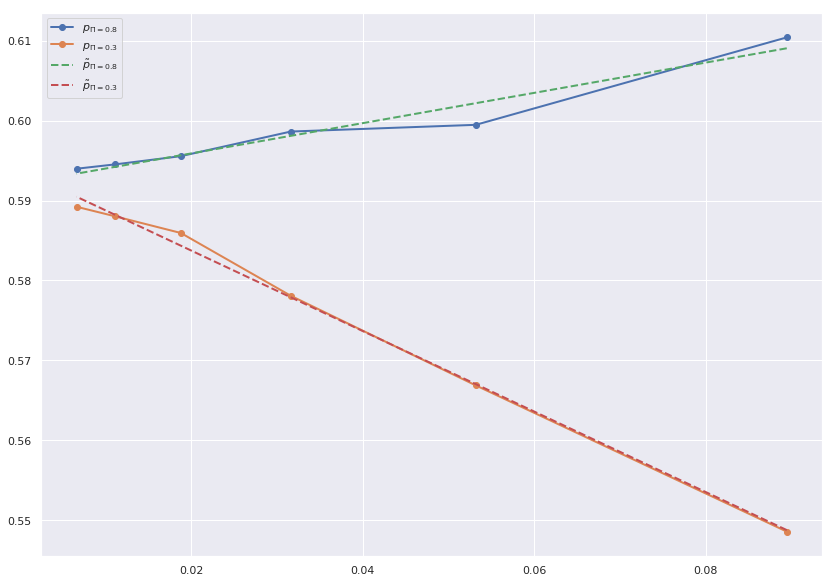

In [52]:
plt.figure(figsize=(14, 10))

L_nu = L_arr ** (-1 / nu_true)

plt.plot(
    L_nu,
    p_pi_high_arr,
    "-o",
    lw=2,
    label=r"$p_{\Pi = 0.8}$"
)
plt.plot(
    L_nu,
    p_pi_low_arr,
    "-o",
    lw=2,
    label=r"$p_{\Pi = 0.3}$"
)

plt.plot(
    L_nu,
    clf_high.predict(L_nu[:, np.newaxis]).ravel(),
    "--",
    lw=2,
    label=r"$\tilde{p}_{\Pi = 0.8}$"
)
plt.plot(
    L_nu,
    clf_low.predict(L_nu[:, np.newaxis]).ravel(),
    "--",
    lw=2,
    label=r"$\tilde{p}_{\Pi = 0.3}$"
)

plt.legend(loc="best")
plt.show()

In the lecture notes we find that we can write the scaling anstatz of the percolation threshold to be
\begin{gather}
    p_{\Pi = x} = p_c + C_x L^{-1 / \nu}
    \implies
    \left(p_{\Pi = x} - p_c\right) L^{1 / \nu} = C_x \equiv \Phi^{-1}(x).
\end{gather}